In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import scipy.integrate
import scipy.stats
import scipy.special
from scipy.special import erf
import scipy.misc

In [15]:
%matplotlib inline

# Run this cell twice for some reason or otherwise it doesn't work
# https://discourse.matplotlib.org/t/bug-rcparams-doesnt-work-first-time-v3-5-2/22853
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [ ]:
file = uproot.open("../../geant/data/bigdatasample/output_75_full_more_shield_re_coincidences_3D.root")
data = file['Pairwise Distances'].arrays(library='pd')

In [48]:
file = uproot.open("../../geant/data/bigdatasample/output_75_full_more_shield_re_coincidences_3D.root")
data = file['Pairwise Distances'].arrays(library='pd')
meta = file['Metadata'].arrays(library='pd')

In [37]:
data = data[data['Particle 2'] == 'e-']

In [49]:
(bars, bins) = np.histogram(data['Distance (mm)'], bins=1000)
width = bins[1] - bins[0]

# Iterations is how many times particlesPerPulse were selected. It is the total number of pulses in 1 second simulated
iterations = meta['Iterations'][0]
particlesPerPulse = meta['Particles Per Pulse'][0]
generatorParticlesPerSecond = 1e6

roi = slice(0, 150)

barsigma = np.where(np.sqrt(bars[roi]) == 0, 1, np.sqrt(bars[roi]))
bars = bars * generatorParticlesPerSecond / iterations / particlesPerPulse
barsigma = barsigma * generatorParticlesPerSecond / iterations / particlesPerPulse

bins = np.convolve(bins, np.ones(2) / 2, mode='valid')

In [50]:
def poly4(x, a, b, c, d):
    return a * x + b * x ** 2 + c * x ** 3 + d * x ** 4

popt, pcov = scipy.optimize.curve_fit(poly4, bins[roi], bars[roi], absolute_sigma=True, sigma=barsigma, bounds=([0, 0, 0, 0],[np.inf, np.inf, np.inf, np.inf]))

fitx = np.linspace(0, np.max(bins[roi]), 1000)
fity = poly4(fitx, *popt)

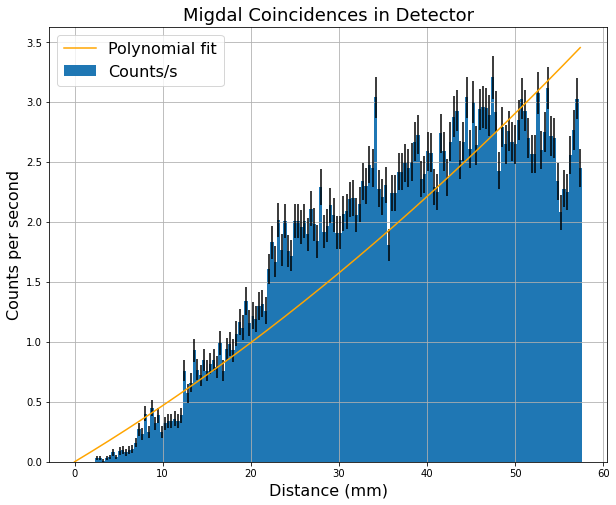

In [51]:
fig, ax = plt.subplots()

ax.bar(bins[roi], bars[roi], width, yerr=barsigma, label='Counts/s')
ax.plot(fitx, fity, color='orange', zorder=10, label='Polynomial fit')

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Distance (mm)', fontsize=16)
ax.set_ylabel('Counts per second', fontsize=16)
ax.set_title('Migdal Coincidences in Detector', fontsize=18)

plt.show()

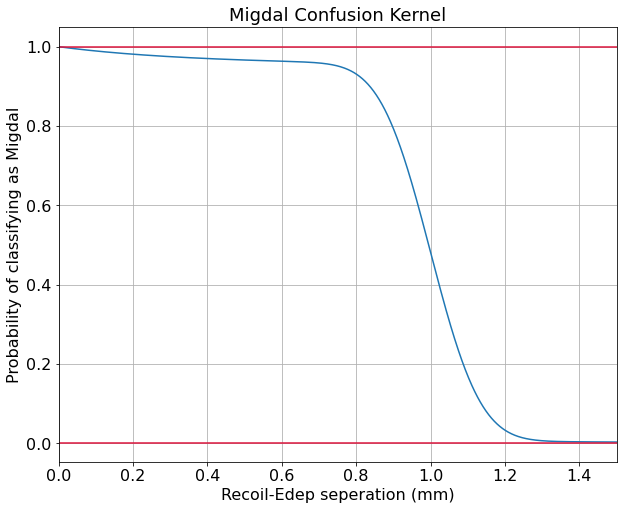

In [47]:
def Kernel(x_list, A, d, w):
    return A * (0.5 * erf((d - x_list) / w) + 0.5) + (1 - A) / ((0.5 * x_list + 1) ** 5)

fig, ax = plt.subplots()

A = 0.95
kernelCenter = 1
w = 0.15

d = np.linspace(0, 1.5, 1000)
confusionKernel = Kernel(d, A, kernelCenter, w)

ax.plot(d, confusionKernel)

ax.axhline(0, color='crimson')
ax.axhline(1, color='crimson')

ax.set_xlim(0, 1.5)

ax.grid()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Recoil-Edep seperation (mm)',fontsize=16)
ax.set_ylabel('Probability of classifying as Migdal',fontsize=16)
ax.set_title('Migdal Confusion Kernel',fontsize=18)

plt.show()

In [42]:
# Area under curve of poly * confusion kernel:
def IntegratedCounts(a, b, c, d, A, kernelCenter, w):
    return scipy.integrate.quad(lambda x : ((poly4(x, a, b, c, d)) * (Kernel(x, A, kernelCenter, w))), 0, kernelCenter + 50 * w)[0]

# Gradient calculated by mathematica
def GradIntegratedCounts(a, b, c, d, A, kernelCenter, w):
    return np.array(
        [scipy.misc.derivative(lambda a : IntegratedCounts(a, popt[1], popt[2], popt[3], A, kernelCenter, w), popt[0], 0.01),
         scipy.misc.derivative(lambda b : IntegratedCounts(popt[0], b, popt[2], popt[3], A, kernelCenter, w), popt[1], 0.01),
         scipy.misc.derivative(lambda c : IntegratedCounts(popt[0], popt[1], c, popt[3], A, kernelCenter, w), popt[2], 0.01),
         scipy.misc.derivative(lambda d : IntegratedCounts(popt[0], popt[1], popt[2], d, A, kernelCenter, w), popt[3], 0.01)
        ]
    )

def CoincidencesPerSecond(A, kernelCenter, w):
    coincidencesPerSecond = IntegratedCounts(*popt, A, kernelCenter, w)
    errcoincidencesPerSecond = np.sqrt(pcov @ GradIntegratedCounts(*popt, A, kernelCenter, w) @ GradIntegratedCounts(*popt, A, kernelCenter, w))
    
    return (coincidencesPerSecond, errcoincidencesPerSecond)

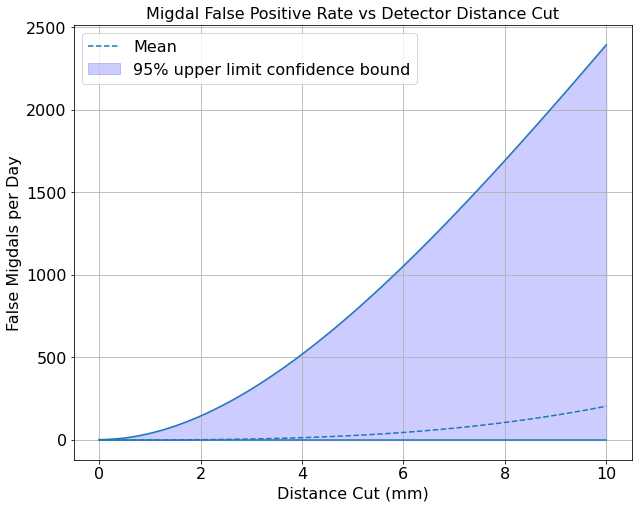

In [43]:
distanceCuts = np.linspace(0, 10, 100)

A = 0.9
w = 0.15

coincidencesPerSecond = np.array([np.array(CoincidencesPerSecond(A, d, w)) for d in distanceCuts])
errcoincidencesPerSecond = coincidencesPerSecond[:, 1]
coincidencesPerSecond = coincidencesPerSecond[:, 0]

coincidencesPerDay = coincidencesPerSecond * 24 * 3600
upperboundPerDay = (coincidencesPerSecond + 1.64 * errcoincidencesPerSecond) * 24 * 3600
lowerboundPerDay = np.zeros_like(upperboundPerDay)
#lowerboundPerDay = (coincidencesPerSecond - 1.96 * errcoincidencesPerSecond) * 24 * 3600
#lowerboundPerDay = np.where(lowerboundPerDay < 0, 0, lowerboundPerDay)

fig, ax = plt.subplots()

ax.plot(distanceCuts, upperboundPerDay, color='tab:blue')
ax.plot(distanceCuts, lowerboundPerDay, color='tab:blue')
ax.plot(distanceCuts, coincidencesPerDay, '--', color='tab:blue', label='Mean')

ax.fill_between(distanceCuts, lowerboundPerDay, upperboundPerDay, color='blue', alpha=.2, label='95% upper limit confidence bound')

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Distance Cut (mm)', fontsize=16)
ax.set_ylabel('False Migdals per Day', fontsize=16)
ax.set_title('Migdal False Positive Rate vs Detector Distance Cut', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

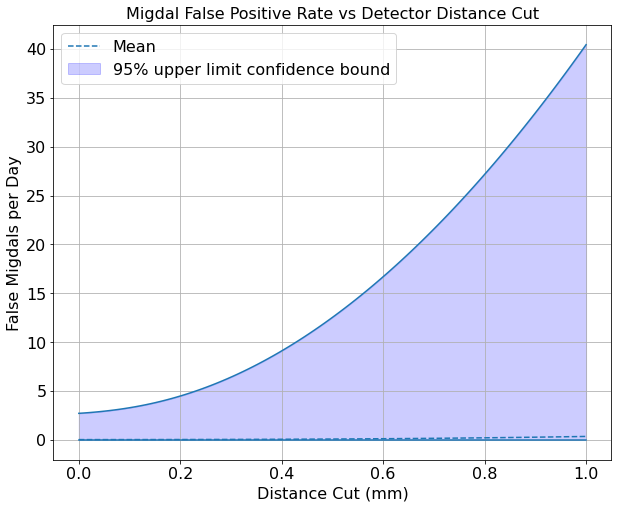

In [44]:
distanceCuts = np.linspace(0, 1, 100)

A = 0.9
w = 0.15

coincidencesPerSecond = np.array([np.array(CoincidencesPerSecond(A, d, w)) for d in distanceCuts])
errcoincidencesPerSecond = coincidencesPerSecond[:, 1]
coincidencesPerSecond = coincidencesPerSecond[:, 0]

coincidencesPerDay = coincidencesPerSecond * 24 * 3600
upperboundPerDay = (coincidencesPerSecond + 1.64 * errcoincidencesPerSecond) * 24 * 3600
lowerboundPerDay = np.zeros_like(upperboundPerDay)
#lowerboundPerDay = (coincidencesPerSecond - 1.96 * errcoincidencesPerSecond) * 24 * 3600
#lowerboundPerDay = np.where(lowerboundPerDay < 0, 0, lowerboundPerDay)

fig, ax = plt.subplots()

ax.plot(distanceCuts, upperboundPerDay, color='tab:blue')
ax.plot(distanceCuts, lowerboundPerDay, color='tab:blue')
ax.plot(distanceCuts, coincidencesPerDay, '--', color='tab:blue', label='Mean')

ax.fill_between(distanceCuts, lowerboundPerDay, upperboundPerDay, color='blue', alpha=.2, label='95% upper limit confidence bound')

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Distance Cut (mm)', fontsize=16)
ax.set_ylabel('False Migdals per Day', fontsize=16)
ax.set_title('Migdal False Positive Rate vs Detector Distance Cut', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()